# SimPEG marlim model

In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
from SimPEG import Data
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

##  Create an OcTree mesh that is refined around resistivity changes

In [2]:
data = np.load('../marlim_comp.npz')  #  or 'marlim_orig.npz'
tres_h = data['res_h']
tres_v = data['res_v']

# We have to add an air layer
hz = np.r_[data['hz'], 20]

mesh_full = discretize.TensorMesh(
    [data['hx'], data['hy'], hz], x0=data['x0']
)

# Add air resistivity
res_h_full = 1e8*np.ones(mesh_full.vnC)
res_v_full = 1e8*np.ones(mesh_full.vnC)
res_h_full[:, :, :-1] = tres_h
res_v_full[:, :, :-1] = tres_v
del data, tres_h, tres_v

mesh_full

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

In [3]:
%%time
# compute the total gradient
dmdx_h = np.abs(mesh_full._cellGradxStencil * mkvc(res_h_full))
dmdy_h = np.abs(mesh_full._cellGradyStencil * mkvc(res_h_full))
dmdz_h = np.abs(mesh_full._cellGradzStencil * mkvc(res_h_full))

CPU times: user 13.1 s, sys: 5.87 s, total: 19 s
Wall time: 19 s


In [4]:
%%time
# compute the total gradient
dmdx_v = np.abs(mesh_full._cellGradxStencil * mkvc(res_v_full))
dmdy_v = np.abs(mesh_full._cellGradyStencil * mkvc(res_v_full))
dmdz_v = np.abs(mesh_full._cellGradzStencil * mkvc(res_v_full))

CPU times: user 13.4 s, sys: 5.69 s, total: 19.1 s
Wall time: 19.1 s


In [5]:
dmdx_h_nz = np.nonzero(dmdx_h)[0]
dmdy_h_nz = np.nonzero(dmdy_h)[0]
dmdz_h_nz = np.nonzero(dmdz_h)[0]

In [6]:
dmdx_v_nz = np.nonzero(dmdx_v)[0]
dmdy_v_nz = np.nonzero(dmdy_v)[0]
dmdz_v_nz = np.nonzero(dmdz_v)[0]

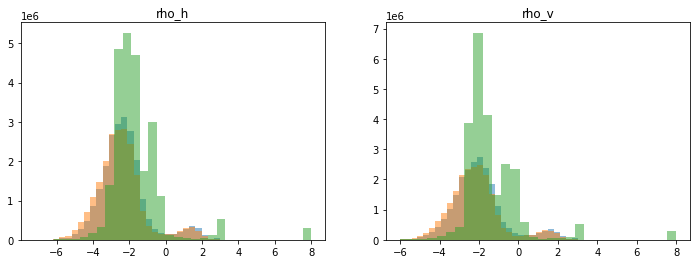

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for dim, h, v in zip(
    ["x", "y", "z"],
    [dmdx_h[dmdx_h_nz], dmdy_h[dmdy_h_nz], dmdz_h[dmdz_h_nz]],
    [dmdx_v[dmdx_v_nz], dmdy_v[dmdy_v_nz], dmdz_v[dmdz_v_nz]]
):

    ax[0].hist(np.log10(np.abs(mkvc(h))), 30, alpha=0.5);
    ax[1].hist(np.log10(np.abs(mkvc(v))), 30, alpha=0.5);

    ax[0].set_title("rho_h")
    ax[1].set_title("rho_v")

In [8]:
# average to cell centers and sum

dmdh = (
    mesh_full.aveFx2CC * dmdx_h + 
    mesh_full.aveFy2CC * dmdy_h + 
    mesh_full.aveFz2CC * dmdz_h
)

dmdv = (
    mesh_full.aveFx2CC * dmdx_v + 
    mesh_full.aveFy2CC * dmdy_v + 
    mesh_full.aveFz2CC * dmdz_v
)

In [9]:
dm = dmdh + dmdv

In [10]:
dm_nonzero = np.nonzero(dm)[0]

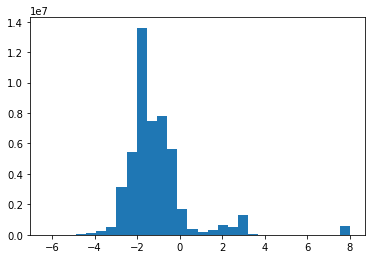

In [12]:
plt.hist(np.log10(dm[dm_nonzero]), 30);

In [13]:
threshold = 1  # Ohm-m
significant_dm = dm >= threshold

In [14]:
significant_dm.sum()

5040738

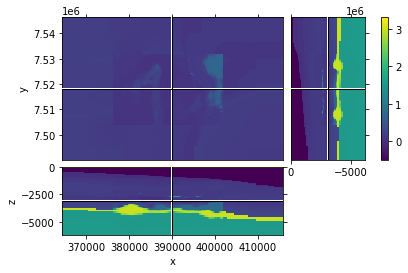

In [15]:
mesh_full.plot_3d_slicer(np.log10(res_h_full),  clim=[np.log10(0.32), np.log10(2000)])

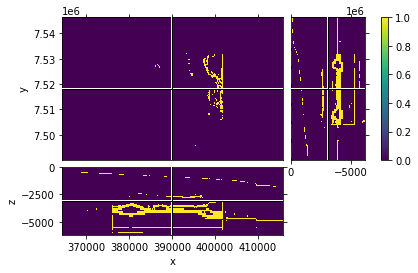

In [16]:
mesh_full.plot_3d_slicer(significant_dm)

## load survey info

In [17]:
ds = xr.load_dataset('../marlim_survey.nc', engine='h5netcdf')

In [18]:
# Use reciprocity: rec becomes src
source = [
    ds.rec_x, ds.rec_y, ds.rec_z,
    ds.rec_theta, ds.rec_dip
]

# Use reciprocity: src becomes rec
rec_x = ds.data_il.src_x[::2]
rec_y_il = ds.data_il.src_y
rec_z_il = ds.data_il.src_z

# Ensure same coordinates
print(np.allclose(rec_x, ds.data_bs.src_x[::2]))

rec_y_bs = ds.data_bs.src_y
rec_z_bs = ds.data_bs.src_z

rec_locs_il = np.vstack([rec_x.data, np.ones_like(rec_x.data)*rec_y_il, rec_z_il]).T
rec_locs_bs = np.vstack([rec_x.data, np.ones_like(rec_x.data)*rec_y_bs, rec_z_bs]).T

# Frequency
freqs = ds.freqs.values

True


In [19]:
print(rec_x.max() - rec_x.min())
print(rec_y_il.max() - rec_y_il.min())
print(rec_y_bs.max() - rec_y_bs.min())
print(rec_z_il.max() - rec_z_il.min())
print(rec_z_bs.max() - rec_z_bs.min())

print(rec_z_bs.min(), rec_z_bs.max())
print(rec_z_il.min(), rec_z_il.max())

<xarray.DataArray 'src_x' ()>
array(21800., dtype=float32)
0.0
0.0
432.17328
429.44952
-1053.3586 -623.9091
-1034.6903 -602.517


In [20]:
# # only refine in the core region where we are collecting data 

extra_x = 1000.
extra_y = 2000.
extra_z = 2000.

survey_x = np.r_[
    rec_x.data.min() - extra_x, rec_x.data.max() + extra_x
]
survey_y = np.r_[
    np.hstack([rec_y_il, rec_y_bs]).min() - extra_y, 
    np.hstack([rec_y_il, rec_y_bs]).max() + extra_y
]
survey_z = np.r_[
    np.hstack([rec_z_il, rec_z_bs]).min() - extra_z, 
    np.hstack([rec_z_il, rec_z_bs]).max() + extra_z/2.
]

print(survey_x)
print(survey_y)
print(survey_z)

[378375. 402175.]
[7514812. 7519812.]
[-3053.35864258   397.48297119]


## design a mesh

In [21]:
dx, dy, dz = 100, 100, 40

domain_x = np.diff(survey_x)
domain_y = 0.4*domain_x 
domain_z = np.diff(survey_z)

pad_x = 40000
pad_y = 40000
pad_z = 40000

length_x = pad_x * 2 + domain_x
length_y = pad_y * 2 + domain_y
length_z = pad_z * 2 + domain_z

nx = int(length_x/dx)
ny = int(length_y/dy)
nz = int(length_z/dz)

nx = 2**int(np.ceil(np.log(nx)/np.log(2.)))
ny = 2**int(np.ceil(np.log(ny)/np.log(2.)))
nz = 2**int(np.ceil(np.log(nz)/np.log(2.)))

print(nx, ny, nz)

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy
hz = np.ones(nz) * dz

mesh = discretize.TreeMesh([hx, hy, hz])

2048 1024 4096


In [22]:
mesh_full_center = np.r_[
    (mesh_full.gridCC[:, 0].min() + mesh_full.gridCC[:, 0].max())/2,
    (mesh_full.gridCC[:, 1].min() + mesh_full.gridCC[:, 1].max())/2,
    (mesh_full.gridCC[:, 2].min() + mesh_full.gridCC[:, 2].max())/2
]

mesh.x0 = np.r_[
    -np.sum(mesh.h[0])/2. + mesh_full_center[0], 
    -np.sum(mesh.h[1])/2. + mesh_full_center[1], 
    -np.sum(mesh.h[2]*3/4.)
] 

In [23]:
# define the base mesh


# refine around the sources and receivers
src_refine = np.c_[source[0], source[1], source[2]]

mesh = discretize.utils.refine_tree_xyz(
    mesh, src_refine, 
    octree_levels=[1, 1, 1], method="radial", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_il, 
    octree_levels=[4, 2, 2], method="radial", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_bs, 
    octree_levels=[4, 2, 2], method="radial", finalize=False
)


In [24]:
# air interface
xrefine = survey_x
yrefine = survey_y
xrefine, yrefine, zrefine = np.meshgrid(xrefine, yrefine, np.r_[0])
air_interface = np.c_[mkvc(xrefine), mkvc(yrefine), mkvc(zrefine)]
mesh = discretize.utils.refine_tree_xyz(
    mesh, air_interface, 
    octree_levels=[1, 1], method="surface", finalize=False
)


# return mesh

In [25]:
significant_dm

array([False, False, False, ...,  True,  True,  True])

In [26]:
refine_inds = significant_dm & (
    (mesh_full.gridCC[:, 0] >= survey_x.min()) &
    (mesh_full.gridCC[:, 0] <= survey_x.max()) &
    (mesh_full.gridCC[:, 1] >= survey_y.min()) &
    (mesh_full.gridCC[:, 1] <= survey_y.max()) &
    (mesh_full.gridCC[:, 2] >= survey_z.min()) &
    (mesh_full.gridCC[:, 2] <= survey_z.max()) 
)
print(refine_inds.sum())
refine_points = mesh_full.gridCC[refine_inds, :]

mesh = discretize.utils.refine_tree_xyz(
    mesh, refine_points, 
    octree_levels=[1, 1], method="radial", finalize=False
)

mesh.finalize()

78627


In [27]:
mesh_full

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

In [28]:
mesh

OcTreeMesh,0.00% filled
Level,Number of cells
1,2
2,24
3,160
4,212
5,263
6,504
7,1006
8,2579
9,11032


In [29]:
mesh.x0

array([ 287675., 7466999., -122880.])

(<matplotlib.cm.ScalarMappable at 0x7f1ff0413040>,)

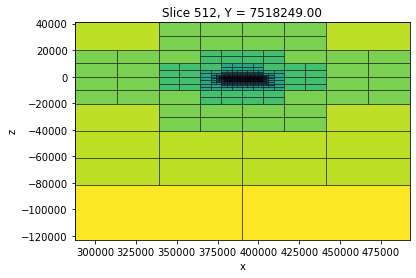

In [30]:
fig, ax = plt.subplots(1, 1)
mesh.plotSlice(np.log10(mesh.vol), normal='y', grid=True, ax=ax)
# ax.set_xlim(mesh.x0[1] + np.r_[-1, 1]*domain_y)

# ax.set_xlim(src[0] + 10000*np.r_[-1, 1])
# ax.set_ylim(np.r_[-4000, 100])

# ax.plot(src[0], src[2], 'ro')

## Interpolate model from base mesh to simulation mesh

In [31]:
# Use volume averaging in log space
from discretize.utils.interputils import volume_average
rhoh = np.exp(volume_average(mesh_full, mesh, np.log(mkvc(res_h_full))))
rhov = np.exp(volume_average(mesh_full, mesh, np.log(mkvc(res_v_full))))

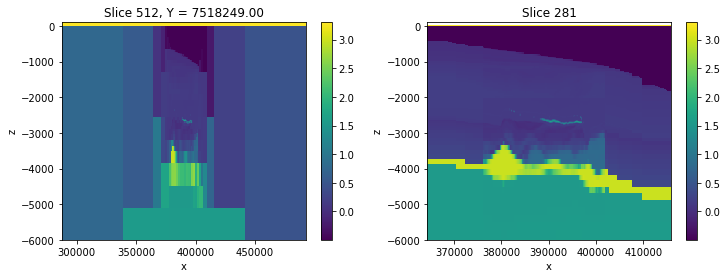

In [32]:
normal = "y"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh.plotSlice(
        np.log10(rhoh), normal=normal, ax=ax[0], clim=[np.log10(0.32), np.log10(2000)])[0], 
    ax=ax[0]
)

plt.colorbar(
    mesh_full.plotSlice(
        np.log10(mkvc(res_h_full)), normal=normal, ax=ax[1], clim=[np.log10(0.32), np.log10(2000)])[0], 
    ax=ax[1]
)


for a in ax: 
    a.set_ylim(np.r_[-6000, 100])
#     a.set_xlim(mesh.x0[1] + np.r_[-1, 1]*domain_x)

In [33]:
rho = np.vstack([rhoh, rhoh, rhov]).T

In [34]:
del mesh_full
del res_h_full
del res_v_full

# set up the survey

In [35]:
rx_list_e = []
rx_list_h = []
for rxlocs in [rec_locs_il, rec_locs_bs]:
    for orientation in ["x", "y", "z"]: 
        # e-field
        rx_list_e.append(
            fdem.receivers.Point_e(locations=rxlocs, orientation=orientation, component="real")
        )
        rx_list_e.append(
                fdem.receivers.Point_e(locations=rxlocs, orientation=orientation, component="imag")
        )
        
        # h-field
        rx_list_h.append(
            fdem.receivers.Point_h(locations=rxlocs, orientation=orientation, component="real")
        )
        rx_list_h.append(
            fdem.receivers.Point_h(locations=rxlocs, orientation=orientation, component="imag")
        )

In [36]:
rx_list = rx_list_e + rx_list_h

In [37]:
Ps = mesh.getInterpolationMat(np.c_[source[0], source[1], source[2]], 'Ex')

In [38]:
src_ex = Ps.T @ np.r_[1]

In [39]:
mesh.gridEx[np.where(src_ex)[0], :]

array([[ 3.902250e+05,  7.517799e+06, -8.800000e+02],
       [ 3.902250e+05,  7.517799e+06, -8.400000e+02],
       [ 3.902250e+05,  7.517899e+06, -8.800000e+02],
       [ 3.902250e+05,  7.517899e+06, -8.400000e+02]])

In [40]:
source_list = [
    fdem.sources.RawVec_e(s_e=src_ex, freq=f, receiver_list=rx_list) 
    for f in freqs
]

In [41]:
survey = fdem.Survey(source_list)

## Setup and run the simulation

In [43]:
sim = fdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey, solver=Pardiso, rho=rho
)

In [45]:
%%time
t0 = time.time()
mem = %memit -o fields = sim.fields()
time_marlim = time.time()-t0
ram = f"{(mem.mem_usage[0] - mem.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram}")

peak memory: 31539.01 MiB, increment: 13138.02 MiB
memory usage: 12.830 GiB
CPU times: user 23min 53s, sys: 34.6 s, total: 24min 28s
Wall time: 7min 2s


In [46]:
dpred = sim.dpred(f=fields)

In [47]:
data = Data(dobs=dpred, survey=survey)

In [48]:
data_il = np.zeros((rec_locs_il.shape[0]*2, len(source_list), 6))
data_bs = np.zeros((rec_locs_bs.shape[0]*2, len(source_list), 6))

## Plot the results

In [50]:
for i, src in enumerate(source_list):
    rx_list = src.receiver_list
    
    for j, offset in enumerate([0, 12]): # electric first, then magnetic
        # inline 
        data_il[0::2, i, 0+3*j] = data[src, rx_list[0+offset]] # x, real
        data_il[1::2, i, 0+3*j] = data[src, rx_list[1+offset]] # x, imag

        data_il[0::2, i, 1+3*j] = data[src, rx_list[2+offset]] # y, real
        data_il[1::2, i, 1+3*j] = data[src, rx_list[3+offset]] # y, imag

        data_il[0::2, i, 2+3*j] = data[src, rx_list[4+offset]] # z, real
        data_il[1::2, i, 2+3*j] = data[src, rx_list[5+offset]] # z, imag

        #  broadside
        data_bs[0::2, i, 0+3*j] = data[src, rx_list[6+offset]] # x, real
        data_bs[1::2, i, 0+3*j] = data[src, rx_list[7+offset]] # x, imag

        data_bs[0::2, i, 1+3*j] = data[src, rx_list[8+offset]] # y, real
        data_bs[1::2, i, 1+3*j] = data[src, rx_list[9+offset]] # y, imag

        data_bs[0::2, i, 2+3*j] = data[src, rx_list[10+offset]] # z, real
        data_bs[1::2, i, 2+3*j] = data[src, rx_list[11+offset]] # z, imag
    


In [51]:
simpeg_data = {
    "data_il": data_il,
    "data_bs": data_bs
}

In [55]:
ds.data_bs.data[:, :, :] = data_bs
ds.data_il.data[:, :, :] = data_il

In [56]:
# Receiver positions (reciprocity)
offs = ds.data_il.src_x[::2] - ds.rec_x

# Line styles
ls = ['co', 'ys', 'm*', 'gd', 'rv', 'b^']

def extract_line(d, n, b=None):
    data = getattr(d, n)
    data = np.abs(data.data[::2, :, :] + 1j*data.data[1::2, :, :])
    
    if b is not None:
        comp = getattr(b, n)
        comp = np.abs(comp.data[::2, :, :] + 1j*comp.data[1::2, :, :])
        
        data -= comp

    return data

In [57]:
data = xr.load_dataset('../marlim_data.nc', engine='h5netcdf')
egd = xr.load_dataset('../results/marlim_emg3d.nc', engine='h5netcdf')
cst = xr.load_dataset('../results/marlim_custEM_p2.nc', engine='h5netcdf')
ptg = xr.load_dataset('../results/marlim_petgem.nc', engine='h5netcdf')

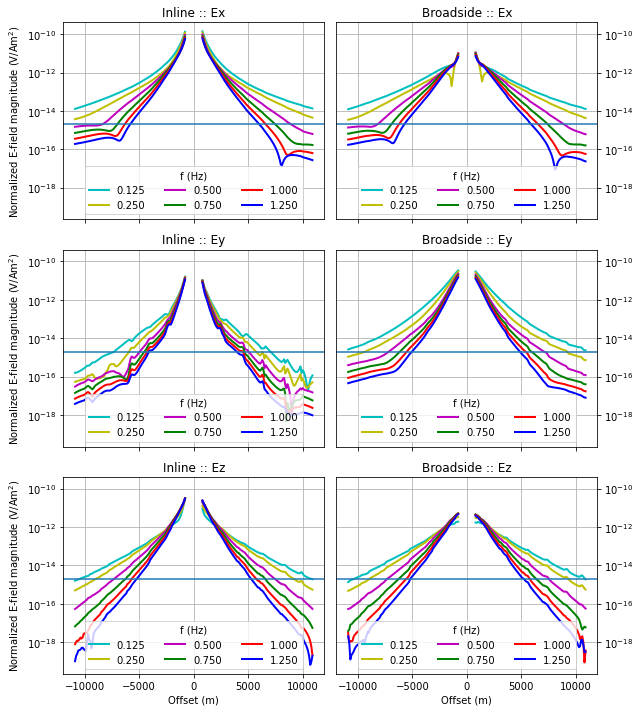

In [58]:
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ds, datname)

    # Loop over components Ex, Ey, Ez
    for ii, comp in enumerate(data.components.values[:3]):

        plt.sca(axs[ii, iii])
        plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

        # Loop over frequencies
        for i, freq in enumerate(data.freqs.values):

            # Plot this component/frequency
            plt.plot(offs[:102], tptg[:102, i, ii], ls[i][0]+'-', lw=2, label=f"{freq:4.3f}")
            plt.plot(offs[102:], tptg[102:, i, ii], ls[i][0]+'-', lw=2)      

        plt.axhline(2e-15)
        plt.legend(title='f (Hz)', loc='lower center', ncol=3)
        plt.grid('on')
        plt.yscale('log')
        
        if ii == 2:
            plt.xlabel('Offset (m)')
        if iii == 0:
            plt.ylabel('Normalized E-field magnitude (V/Am$^2$)')
        else:
            axs[ii, iii].yaxis.set_ticks_position('right')
            axs[ii, iii].yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

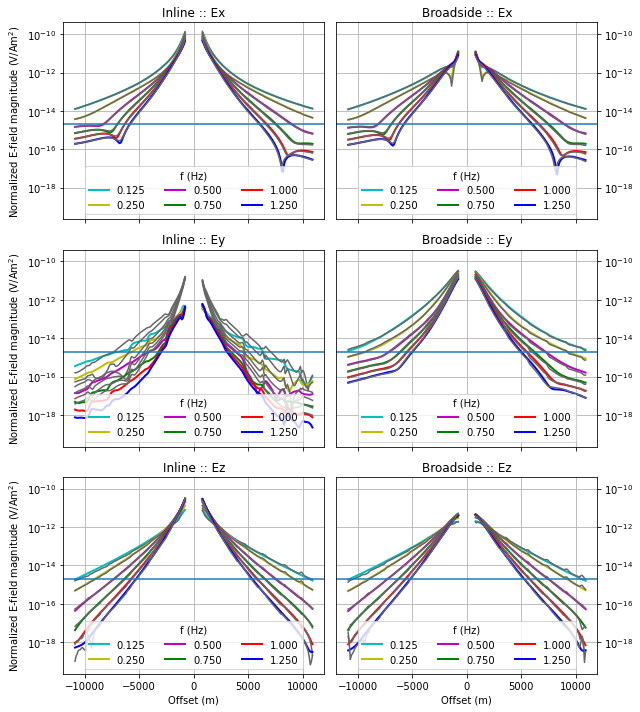

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ds, datname)

    # Loop over components Ex, Ey, Ez
    for ii, comp in enumerate(data.components.values[:3]):

        plt.sca(axs[ii, iii])
        plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

        # Loop over frequencies
        for i, freq in enumerate(data.freqs.values):

            # Plot this component/frequency
            plt.plot(offs[:102], tdat[:102, i, ii], ls[i][0]+'-', lw=2, label=f"{freq:4.3f}")
            plt.plot(offs[102:], tdat[102:, i, ii], ls[i][0]+'-', lw=2)
#             plt.plot(offs[:102], tegd[:102, i, ii], 'k--')
#             plt.plot(offs[102:], tegd[102:, i, ii], 'k--')
#             plt.plot(offs[:102], tcst[:102, i, ii], '-.', c='.2')
#             plt.plot(offs[102:], tcst[102:, i, ii], '-.', c='.2')
            plt.plot(offs[:102], tptg[:102, i, ii], '-k', c='.4')
            plt.plot(offs[102:], tptg[102:, i, ii], '-k', c='.4')      

        plt.axhline(2e-15)
        plt.legend(title='f (Hz)', loc='lower center', ncol=3)
        plt.grid('on')
        plt.yscale('log')
        
        if ii == 2:
            plt.xlabel('Offset (m)')
        if iii == 0:
            plt.ylabel('Normalized E-field magnitude (V/Am$^2$)')
        else:
            axs[ii, iii].yaxis.set_ticks_position('right')
            axs[ii, iii].yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

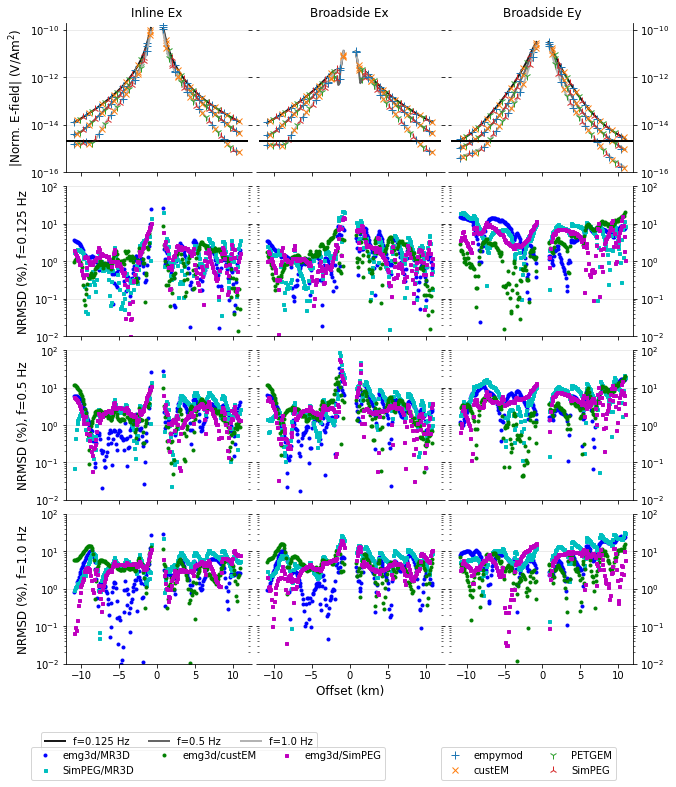

In [60]:
fs = 12
fig, axs = plt.subplots(4, 3, figsize=(9.5, 11), sharex=True)

ls = ['-', ':', '--', '-.']
ms = 8

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ptg, datname)
    tspg = extract_line(ds, datname) # tegd  ### CHANGE TO SimPEG

    # Loop over components Ex, Ey, Ez
    if datname == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):
        
        # Fields
        for ii, comp in enumerate(values):

            plt.sca(axs[0, ii+iii])
            plt.title(f"{['Inline', 'Broadside'][iii]} {comp}")


            # Plot this component/frequency
            plt.plot(offs[:102]/1e3, tdat[:102, i, ii], str(.1+i*.3), lw=2,
                     label=f"f={freq} Hz" if ii+iii == 0 else None)
            plt.plot(offs[102:]/1e3, tdat[102:, i, ii], str(.1+i*.3), lw=2)
            
            plt.plot(offs[:102:16]/1e3, tegd[:102:16, i, ii], 'C0', ls="", marker="+", ms=ms,
                     label=f"empymod" if (i == 0 and ii+iii == 1) else None)
            plt.plot(offs[102::16]/1e3, tegd[102::16, i, ii], 'C0', ls="", marker="+", ms=ms)
            
            plt.plot(offs[4:102:16]/1e3, tcst[4:102:16, i, ii], 'C1', ls="", marker="x", ms=ms-2)
            plt.plot(offs[106::16]/1e3, tcst[106::16, i, ii], 'C1', ls="", marker="x", ms=ms-2,
                     label=f"custEM" if (i == 0 and ii+iii == 1) else None)
            
            plt.plot(offs[8:102:16]/1e3, tptg[8:102:16, i, ii], 'C2', ls="", marker="1", ms=ms)
            plt.plot(offs[110::16]/1e3, tptg[110::16, i, ii], 'C2', ls="", marker="1", ms=ms,
                     label=f"PETGEM" if (i == 0 and ii+iii == 1) else None)
            
            plt.plot(offs[12:102:16]/1e3, tspg[12:102:16, i, ii], 'C3', ls="", marker="2", ms=ms)
            plt.plot(offs[114::16]/1e3, tspg[114::16, i, ii], 'C3', ls="", marker="2", ms=ms,
                     label=f"SimPEG" if (i == 0 and ii+iii == 1) else None)

            plt.axhline(2e-15, c='k')           
    
            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-16, 2e-10])
            if ii+iii == 2:
                axs[0, 2].yaxis.tick_right()
            axs[0, ii+iii].yaxis.set_ticks_position('both')

        axs[0, 0].set_ylabel('|Norm. E-field| (V/Am$^2$)', fontsize=fs)
        axs[0, 1].set_yticklabels(())

        # Error
        for ii, comp in enumerate(values):

            plt.sca(axs[1+i, ii+iii])

            # Plot difference
            dat_egd = 200*np.abs((tdat[:, i, ii]-tegd[:, i, ii])/(tdat[:, i, ii]+tegd[:, i, ii]))
            dat_cst = 200*np.abs((tdat[:, i, ii]-tcst[:, i, ii])/(tdat[:, i, ii]+tcst[:, i, ii]))
            dat_ptg = 200*np.abs((tdat[:, i, ii]-tptg[:, i, ii])/(tdat[:, i, ii]+tptg[:, i, ii]))
            dat_spg = 200*np.abs((tdat[:, i, ii]-tspg[:, i, ii])/(tdat[:, i, ii]+tspg[:, i, ii]))
            
            egd_cst = 200*np.abs((tegd[:, i, ii]-tcst[:, i, ii])/(tegd[:, i, ii]+tcst[:, i, ii]))
            cst_ptg = 200*np.abs((tcst[:, i, ii]-tptg[:, i, ii])/(tcst[:, i, ii]+tptg[:, i, ii]))
            egd_ptg = 200*np.abs((tegd[:, i, ii]-tptg[:, i, ii])/(tegd[:, i, ii]+tptg[:, i, ii]))
            egd_spg = 200*np.abs((tegd[:, i, ii]-tspg[:, i, ii])/(tegd[:, i, ii]+tspg[:, i, ii]))
            
            plt.plot(offs/1e3, dat_egd, 'b.', label="emg3d/MR3D" if i == 0 else None)
#             plt.plot(offs/1e3, dat_cst, 'm.', label="custEM/MR3D" if i == 0 else None)
#             plt.plot(offs/1e3, dat_ptg, 'rx', ms=3, label="PETGEM/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_spg, 'cs', ms=3, label="SimPEG/MR3D" if i == 0 else None)
            
            plt.plot(offs/1e3, egd_cst, 'g.', label="emg3d/custEM" if i == 0 else None)
#             plt.plot(offs/1e3, cst_ptg, 'y.', label="custEM/PETGEM" if i == 0 else None)
#             plt.plot(offs/1e3, egd_ptg, 'kx', ms=3, label="emg3d/PETGEM" if i == 0 else None)
            plt.plot(offs/1e3, egd_spg, 'ms', ms=3, label="emg3d/SimPEG" if i == 0 else None)

            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-2, 1e2])
            if ii+iii == 2:
                axs[1+i, 2].yaxis.tick_right()
            axs[1+i, ii+iii].yaxis.set_ticks_position('both')

        axs[1+i, 0].set_ylabel(f'NRMSD (%), f={freq} Hz', fontsize=fs)
        axs[1+i, 1].set_yticklabels(())

    axs[3, 1].set_xlabel('Offset (km)', fontsize=fs)


# Switch off spines
for i in range(4):
    for ii in range(3):
        axs[i, ii].spines['top'].set_visible(False)
    for ii in range(2):
        axs[i, ii].spines['right'].set_visible(False)
    for ii in range(1, 3):
        axs[i, ii].spines['left'].set_visible(False)
        
plt.tight_layout(h_pad=0.02, rect=[0, 0.1, 1, 1])

plt.sca(axs[0, 1])
plt.legend(bbox_to_anchor=(0.65, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=2)  
plt.sca(axs[0, 0])
plt.legend(bbox_to_anchor=(0.05, 0.035), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=1., ncol=3)  

plt.sca(axs[1, 0])
plt.legend(bbox_to_anchor=(0.05, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=3)  
                
# plt.savefig(f'../manuscript/figures/results-marlim_2.pdf', bbox_inches='tight')
plt.show()

In [61]:
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tspg = extract_line(ds, datname) 

    # Loop over components Ex, Ey, Ez
    if datname == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):
        
        # Fields
        for ii, comp in enumerate(values): 
            err = 200*np.abs((tdat[:, i, ii]-tspg[:, i, ii])/(tdat[:, i, ii]+tspg[:, i, ii]))
            print(
                f"{datname} {comp} {freq:1.3f} Hz - mean: {np.mean(err):1.2f}, median: {np.median(err):1.2f}"
            )

data_il Ex 0.125 Hz - mean: 1.53, median: 1.01
data_il Ex 0.500 Hz - mean: 2.97, median: 2.51
data_il Ex 1.000 Hz - mean: 5.36, median: 4.96
data_bs Ex 0.125 Hz - mean: 2.50, median: 1.50
data_bs Ey 0.125 Hz - mean: 6.90, median: 6.62
data_bs Ex 0.500 Hz - mean: 5.36, median: 2.53
data_bs Ey 0.500 Hz - mean: 7.33, median: 7.19
data_bs Ex 1.000 Hz - mean: 6.75, median: 5.74
data_bs Ey 1.000 Hz - mean: 11.31, median: 9.80


In [62]:
import SimPEG
from datetime import datetime

In [63]:
# Add info
ds.attrs['runtime'] = time_marlim
ds.attrs['n_procs'] = 1
ds.attrs['max_ram'] = ram
ds.attrs['n_cells'] = f"({mesh.nC}"
ds.attrs['n_nodes'] = 'N/A'
ds.attrs['n_dof'] = f"({mesh.nE})"
ds.attrs['extent'] = (f"x = {mesh.vectorNx[0]:.1f}-{mesh.vectorNx[-1]:.1f}; " # Total mesh extent
                      f"y = {mesh.vectorNy[0]:.1f}-{mesh.vectorNy[-1]:.1f}; "
                      f"z = {mesh.vectorNz[0]:.1f}-{mesh.vectorNz[-1]:.1f}")
ds.attrs['min_vol'] = f"{np.min(mesh.vol):.1f}"
ds.attrs['max_vol'] = f"{np.max(mesh.vol):.1f}"
ds.attrs['machine'] = "GKE n2-custom (8 vCPUs, 130 GB memory); Intel Cascade Lake; Ubuntu-1604-xenial"
ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
ds.attrs['date'] = datetime.today().isoformat()


# Save it under <{model}_{code}.nc>
ds.to_netcdf(f"../results/marlim_simpeg.nc", engine='h5netcdf')
ds

<xarray.Dataset>
Dimensions:     (components: 6, freqs: 6, src_x: 408)
Coordinates:
  * components  (components) object 'Ex' 'Ey' 'Ez' 'Hx' 'Hy' 'Hz'
  * freqs       (freqs) float32 0.125 0.25 0.5 0.75 1.0 1.25
  * src_x       (src_x) float32 379375.0 379375.0 379475.0 ... 401175.0 401175.0
Data variables:
    data_bs     (src_x, freqs, components) float64 -1.028e-14 ... 9.169e-17
    data_il     (src_x, freqs, components) float64 -1.051e-14 ... -6.753e-17
Attributes:
    date:       2020-09-08T22:05:20.406779
    extent:     x = 287675.0-492475.0; y = 7466999.0-7569399.0; z = -122880.0...
    machine:    GKE n2-custom (8 vCPUs, 130 GB memory); Intel Cascade Lake; U...
    max_ram:    12.830 GiB
    max_vol:    429496729600000.0
    min_vol:    400000.0
    n_cells:    (275542
    n_dof:      (720146)
    n_nodes:    N/A
    n_procs:    1
    rec_dip:    0.0
    rec_theta:  0.0
    rec_x:      390275.0
    rec_y:      7517812.0
    rec_z:      -849.7838
    runtime:    422.0490906238556
    src_dip:    0.0
    src_theta:  0.0
    strength:   1.0
    version:    SimPEG v0.14.2

In [64]:
np.save("simpeg_marlim_fields.npy", fields[:, 'e'])